In [61]:
from __future__ import print_function
import time
import os
import torch
import random
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import matplotlib.pyplot as plt
from skimage.transform import resize

import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm_notebook as tqdm

In [62]:
#parameters
workers = 2
batch_size = 128
image_size = 64
nc = 3
nz = 128
ngf = 64
ndf = 64
num_epochs = 3

beta1 = 0.5
ngpu = 0

LR_G = 0.001
LR_D = 0.0005

beta1 = 0.5


real_label = 0.9
fake_label = 0
z_dim = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

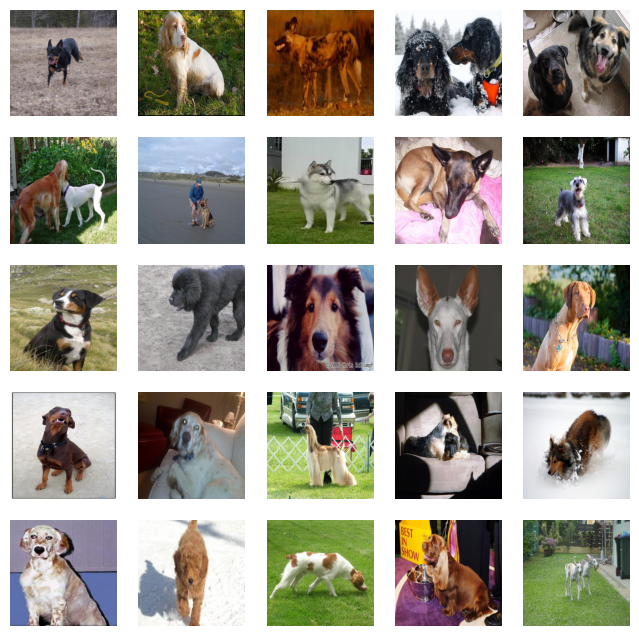

In [63]:
PATH = 'C:/Users/Admin/Downloads/Images'

# Get the list of image filenames in the directory
images = os.listdir(PATH)

# Create subplots to display random images
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(8,8))

# Iterate through the subplots and display random dog images
for indx, axis in enumerate(axes.flatten()):
    PATH_TEMP = random.choice(os.listdir(PATH))
    # Get a random index within the range of available images
    rnd_indx = np.random.randint(0, len(os.listdir(PATH+'/'+PATH_TEMP)))
    
    # Load and display the image using Matplotlib
    images = os.listdir(PATH+'/'+PATH_TEMP+'/')
    img = plt.imread(PATH+'/'+PATH_TEMP + '/'+images[rnd_indx])
    # Resize the image to a constant size (64x64)
 
    img = resize(img, (400,400))
    imgplot = axis.imshow(img)
    axis.set_axis_off()  # Turn off the axis for better visualization

In [64]:
random_transforms = [transforms.ColorJitter(), transforms.RandomRotation(degrees=20)]
transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomApply(random_transforms, p=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder(PATH, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size, num_workers=workers)
                                           
imgs, label = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..0.67058825].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92941177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.88235295..0.92941177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.75686276..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.82745

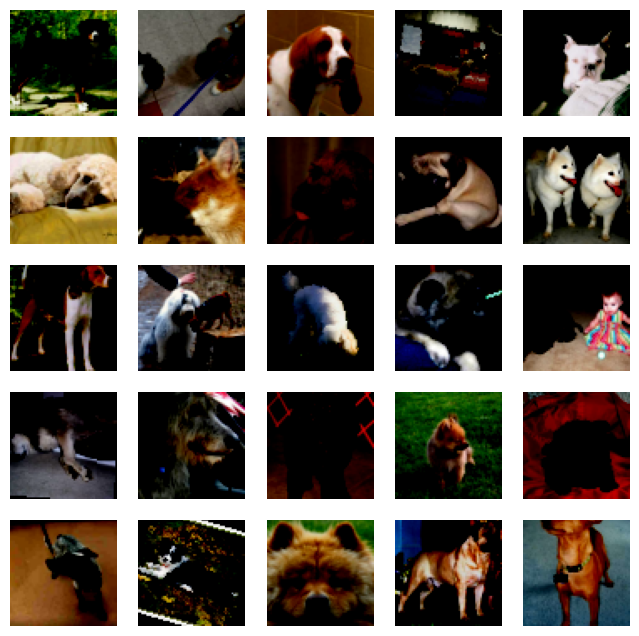

In [65]:
fig, axs = plt.subplots(5,5, figsize = (8,8))

for i in range(5):
    for j in range(5):
        axs[i,j].imshow(imgs[5*i+j])
        axs[i,j].axis('off')

plt.show()

In [66]:
#weight initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [67]:
class Generator_conv_layer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=0, bias=False):
        super(Generator_conv_layer, self).__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            Generator_conv_layer(nz, ngf*8, kernel_size=4, stride=1, padding=0, bias=False),
            Generator_conv_layer(ngf*8, ngf*4, kernel_size=4, stride=2, padding=1, bias=False),
            Generator_conv_layer(ngf*4, ngf*2, kernel_size=4, stride=2, padding=1, bias=False),
            Generator_conv_layer(ngf*2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.gen(x)
        return x
    
class Discriminator_conv_layer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=0, bn=False):
        super(Discriminator_conv_layer, self).__init__()
        if bn:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
            self.bn = nn.BatchNorm2d(out_channels)
            self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)
        else:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
            self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        x = self.conv(x)
        if hasattr(self, 'bn'):
            x = self.bn(x)
        x = self.leaky_relu(x)
        return x
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.dis = nn.Sequential(
            Discriminator_conv_layer(nc, ndf, kernel_size=4, stride=2, padding=1, bn=False),
            Discriminator_conv_layer(ndf, ndf*2, kernel_size=4, stride=2, padding=1, bn=True),
            Discriminator_conv_layer(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1, bn=True),
            Discriminator_conv_layer(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1, bn=True),
            nn.Conv2d(ndf*8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.dis(x)
        return x
    

In [68]:
# Create the generator
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (gen): Sequential(
    (0): Generator_conv_layer(
      (conv): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): Generator_conv_layer(
      (conv): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): Generator_conv_layer(
      (conv): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (3): Generator_conv_layer(
      (conv): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, 

In [69]:
# Create the generator
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (dis): Sequential(
    (0): Discriminator_conv_layer(
      (conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Discriminator_conv_layer(
      (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_relu): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Discriminator_conv_layer(
      (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_relu): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Discriminator_conv_layer(
      (conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, af

In [70]:
criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=LR_D, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR_G, betas=(beta1, 0.999))

fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

G_losses = []
D_losses = []
img_list = []
iters = 0

In [71]:
#training loop
# (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
# (2) Update G network: maximize log(D(G(z)))

for epoch in range(num_epochs):
    for i, data in enumerate(train_loader, 0):
        ## Train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        #loss
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

[0/3][0/161]	Loss_D: 2.0442	Loss_G: 15.5855	D(x): 0.6815	D(G(z)): 0.7238 / 0.0000
[0/3][50/161]	Loss_D: 1.8858	Loss_G: 2.0249	D(x): 0.4111	D(G(z)): 0.4562 / 0.1418
[0/3][100/161]	Loss_D: 1.3139	Loss_G: 1.8304	D(x): 0.4522	D(G(z)): 0.3247 / 0.1561
[0/3][150/161]	Loss_D: 1.1885	Loss_G: 2.2259	D(x): 0.4978	D(G(z)): 0.1725 / 0.1132
[1/3][0/161]	Loss_D: 0.8563	Loss_G: 3.9455	D(x): 0.8513	D(G(z)): 0.3301 / 0.0183
[1/3][50/161]	Loss_D: 0.8783	Loss_G: 3.1692	D(x): 0.6697	D(G(z)): 0.2415 / 0.0454
[1/3][100/161]	Loss_D: 1.3807	Loss_G: 2.3027	D(x): 0.5394	D(G(z)): 0.4371 / 0.1016
[1/3][150/161]	Loss_D: 1.0940	Loss_G: 3.5362	D(x): 0.7253	D(G(z)): 0.4428 / 0.0274
[2/3][0/161]	Loss_D: 1.3042	Loss_G: 4.8233	D(x): 0.7448	D(G(z)): 0.4963 / 0.0099
[2/3][50/161]	Loss_D: 0.8705	Loss_G: 2.1900	D(x): 0.6418	D(G(z)): 0.2336 / 0.1241
[2/3][100/161]	Loss_D: 0.7929	Loss_G: 2.1188	D(x): 0.7406	D(G(z)): 0.2784 / 0.1098
[2/3][150/161]	Loss_D: 1.6194	Loss_G: 1.2050	D(x): 0.2714	D(G(z)): 0.0467 / 0.3139


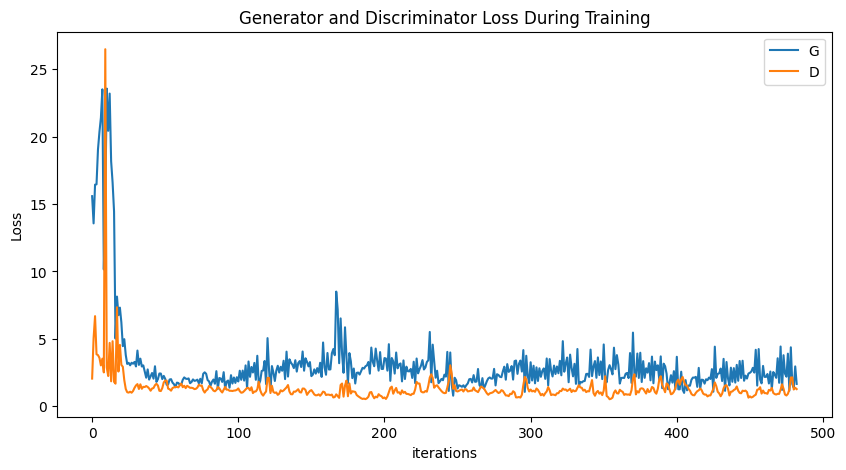

In [72]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

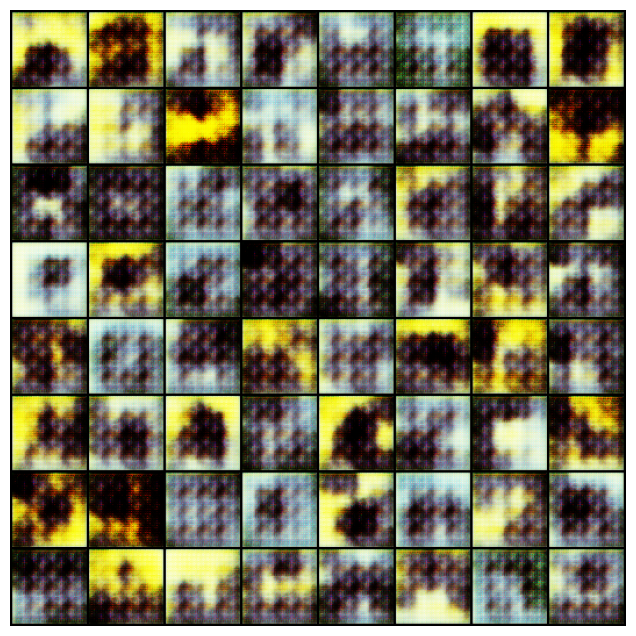

In [73]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
#The above result does not produce very good dog images, but this is related to small scale of this network + low number of epoch. On the other hand, we can clearly see the cnn kernels and how in some pictures they are trying to build out dog's face.
#The network seems to have picked up some patters like darker face features, as well as nose and ears shapes in some cases, but to achieve better results it will need to be increased in scale and train on more epochs.